In [1]:
import scanpy as sc
import scvi
import anndata as ad
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
#import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import pertpy as pt
os.chdir("/data")
sc._settings.ScanpyConfig.n_jobs = 5

In [2]:
adata= sc.read_h5ad("h5ad/batch_corrected.h5ad")

In [3]:
sccoda_model = pt.tl.Sccoda()

In [4]:
sccoda_data = sccoda_model.load(
    adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="annot",
    sample_identifier="sample_id",
    covariate_obs=["condition"],
)

In [5]:
sccoda_data

MuData object with n_obs × n_vars = 137659 × 8008
  2 modalities
    rna:	137651 x 8000
      obs:	'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'vaeda_scores', 'vaeda_calls', 'outlier', 'mt_outlier', 'sample_id', 'condition', '_scvi_batch', '_scvi_labels', 'leiden', 'annot', 'scCODA_sample_id'
      var:	'highly_variable', 'observed_fraction_zeros', 'expected_fraction_zeros', 'prob_zero_enriched_nbatches', 'prob_zero_enrichment', 'prob_zero_enrichment_rank'
      uns:	'_scvi_manager_uuid', '_scvi_uuid', 'annot_colors', 'condition_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'sample_id_colors', 'umap'
      obsm:	'X_scVI', 'X_scVI_MDE', 'X_umap', 'cellbender_embedding', 'vaeda_embedding'
      layers:	'cellbender', 'counts', 'raw'
      obsp:	'connectivities', 'distances'
    coda:	8 x 8
      obs:	'condition', 'sample_id'
      var:	'n_cells'

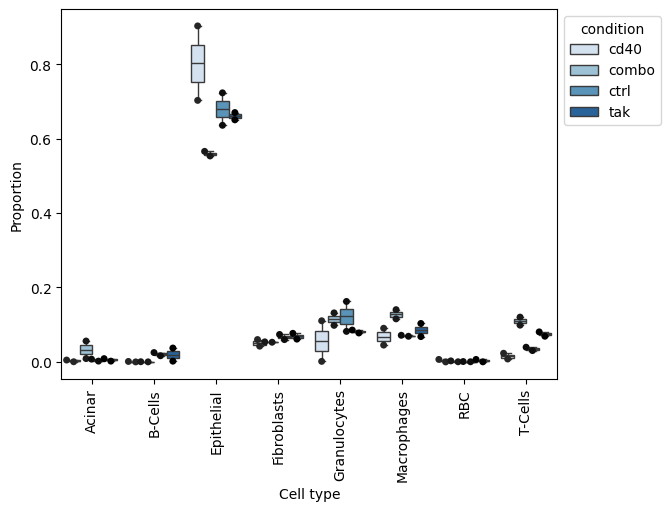

In [6]:
sccoda_model.plot_boxplots(sccoda_data, modality_key="coda", feature_name="condition", add_dots=True)
plt.show()

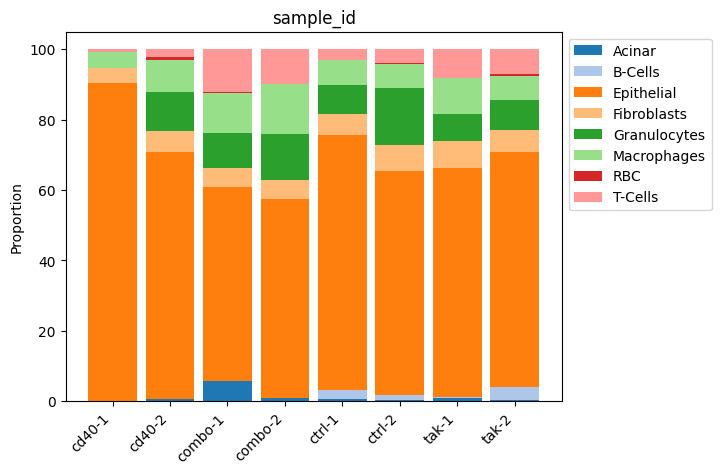

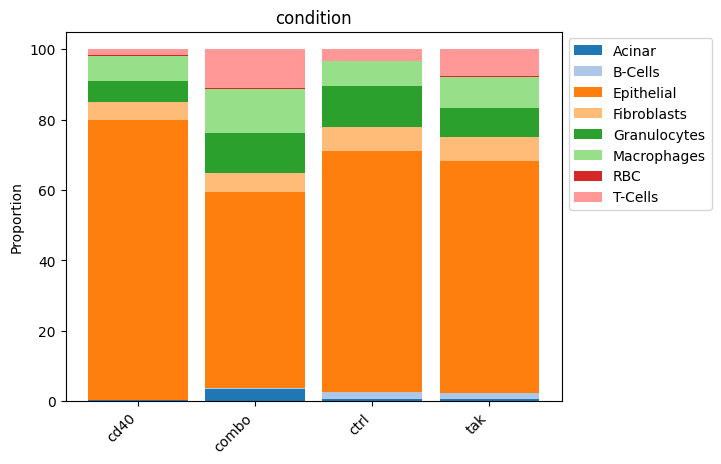

In [7]:
sccoda_model.plot_stacked_barplot(sccoda_data, modality_key="coda", feature_name="sample_id")
plt.show()

sccoda_model.plot_stacked_barplot(sccoda_data, modality_key="coda", feature_name="condition")
plt.show()

<Axes: xlabel='Presence', ylabel='Total dispersion'>

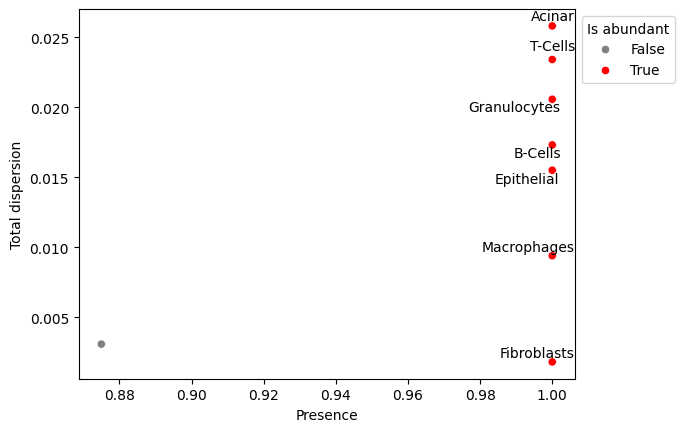

In [8]:
sccoda_model.plot_rel_abundance_dispersion_plot(sccoda_data, modality_key="coda", abundant_threshold=0.95)


In [9]:
sccoda_data.mod["coda"].obs.condition

scCODA_sample_id
cd40-1      cd40
cd40-2      cd40
combo-1    combo
combo-2    combo
ctrl-1      ctrl
ctrl-2      ctrl
tak-1        tak
tak-2        tak
Name: condition, dtype: category
Categories (4, object): ['cd40', 'combo', 'ctrl', 'tak']

In [10]:
comp = ["ctrlvcd40", "ctrlvtak", "ctrlvcombo", "takvcombo", "takvcd40", "cd40vcombo"]
res=[]
for n in comp:
    conds = n.split('v')
    dat = sccoda_model.load(
        adata[adata.obs["condition"].isin(conds)],
        type="cell_level",
        generate_sample_level=True,
        cell_type_identifier="annot",
        sample_identifier="sample_id",
        covariate_obs=["condition"],
        )
    dat=sccoda_model.prepare(dat, 
                             modality_key="coda", 
                             formula=f"C(condition, Treatment('{conds[0]}'))",
                             reference_cell_type="Epithelial")
    sccoda_model.run_nuts(dat, modality_key="coda", rng_key=2949)
    res.append(dat)
    #sccoda_model.summary(dat, modality_key="coda")

• Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [00:11<00:00, 998.37it/s, 127 steps of size 3.79e-02. acc. prob=0.83] 


• Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [00:08<00:00, 1293.93it/s, 49 steps of size 6.18e-02. acc. prob=0.70]


• Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [00:10<00:00, 1079.84it/s, 127 steps of size 4.23e-02. acc. prob=0.71]


In [11]:
for n in res:
    print(sccoda_model.credible_effects(n, modality_key="coda"))

Covariate                                Cell Type   
C(condition, Treatment('ctrl'))[T.cd40]  Acinar          False
                                         B-Cells         False
                                         Epithelial      False
                                         Fibroblasts     False
                                         Granulocytes    False
                                         Macrophages     False
                                         RBC             False
                                         T-Cells         False
Name: Final Parameter, dtype: bool
Covariate                               Cell Type   
C(condition, Treatment('ctrl'))[T.tak]  Acinar          False
                                        B-Cells         False
                                        Epithelial      False
                                        Fibroblasts     False
                                        Granulocytes    False
                                        Macr

In [14]:
comp = ["PTvPT-TX", "GemRvGemR-TX", "PTvGemR", "PTvMRTXR", "GemRvMRTXR"]
res=[]
for n in comp:
    conds = n.split('v')
    sccoda_data = sccoda_model.prepare(
        sccoda_data,
        modality_key="coda",
        formula="C(condition, ,
        reference_cell_type="Epithelial",
    )
sccoda_model.run_nuts(sccoda_data, modality_key="coda")
sccoda_model.summary(sccoda_data, modality_key="coda")

sample: 100%|██████████| 11000/11000 [01:45<00:00, 104.49it/s, 511 steps of size 1.09e-02. acc. prob=0.92]


                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 15 samples, 9 cell types                                    │
│ Reference cell type                         │ Epithelial                                                        │
│ Formula                                     │ condition                                                         │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                  Final Parameter  Expected Sample                                                               │
│ Cell Type                                                                                                       │
│ Acinar               -0.481            64.425                                                                   │
│ Dendritic Cells      -0.073            96.883                                                                   │
│ Epithelial            3.751          4435.963                                                                   │
│ Fibroblast            0.973           275.751                                                                   │
│ Islet                -0.861            44.058                                                                   │
│ Macrophages           1.570           500.947                                                                   │
│ Mast Cells           -1.244            30.039                                                                   │
│ Monocytes??          -1.492            23.441                                                                   │
│ T Cells              -0.564            59.294                                                                   │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                     Final Parameter  Expected Sample  log2-fold change                          │
│ Covariate          Cell Type                                                                                    │
│ conditionT.GemR-TX Acinar               0.000             64.425            0.000                               │
│                    Dendritic Cells      0.000             96.883            0.000                               │
│                    Epithelial           0.000           4435.963            0.000                               │
│                    Fibroblast           0.000            275.751            0.000                               │
│                    Islet                0.000             44.058            0.000                               │
│                    Macrophages          0.000            500.947            0.000                               │
│                    Mast Cells           0.000             30.039            0.000                               │
│                    Monocytes??          0.000             23.441            0.000                               │
│                    T Cells              0.000             59.294            0.000                               │
│ conditionT.MRTXR   Acinar               0.000             64.425            0.000                               │
│                    Dendritic Cells      0.000             96.883            0.000                               │
│                    Epithelial           0.000           4435.963            0.000                               │
│                    Fibroblast           0.000            275.751            0.000                               │
│                    Islet                0.000             44.058            0.000                               │
│                    Macrophages          0.000            500.947            0.000                               │
│                    Mast Cells           0.000             30.039            0.000                               │
│                    Monocytes??          0.000             23.441            0.000                               │
│                    T Cells              0.000             59.294            0.000                               │
│ conditionT.PT      Acinar               0.000             58.903           -0.129                               │
│                    Dendritic Cells      0.000             88.579           -0.129                               │
│                    Epithelial           0.000           4055.769           -0.129                               │
│                    Fibroblast           0.000            252.118           -0.129                               │
│                    Islet                0.000             40.282           -0.129                               │
│                    Macrophages          0.710            932.041            0.896                               │
│                    Mast Cells           0.000             27.465           -0.129                               │
│                    Monocytes??          0.000             21.432           -0.129                               │
│                    T Cells              0.000             54.212           -0.129                               │
│ conditionT.PT-TX   Acinar               0.000             40.122           -0.683                               │
│                    Dendritic Cells      0.000             60.336           -0.683                               │
│                    Epithelial           0.000         

In [12]:
import pandas as pd
comp = ["ctrlvcd40", "ctrlvtak", "ctrlvcombo", "takvcombo", "takvcd40", "cd40vcombo"]
df_list=[]
fdr=[0.1, 0.15, 0.2]
for name, results in zip(comp, res):
    df = sccoda_model.get_effect_df(results, modality_key="coda")
    df['fdr']=0.05
    for x in fdr:
        sccoda_model.set_fdr(results, modality_key="coda", est_fdr=x)
        effects=sccoda_model.get_effect_df(results, modality_key="coda")
        effects['fdr']=x
        df=pd.concat([df, effects])
    df["Comparison"]= name
    df_list.append(df)
final_df=pd.concat(df_list)
final_df["Credible Effect"] = np.where(final_df['Final Parameter']!= 0, True, False)
final_df = final_df.reset_index()
final_df.drop("Covariate", axis=1, inplace=True)
final_df = final_df.loc[:,["Cell Type", "Comparison", "Credible Effect", "fdr", "log2-fold change", "Final Parameter", "HDI 3%", "HDI 97%", "SD", "Inclusion probability", "Expected Sample"]]
final_df.to_csv("da/model_outputs.csv", index=False)
    

In [13]:
final_df

,Cell Type,Comparison,Credible Effect,fdr,log2-fold change,Final Parameter,HDI 3%,HDI 97%,SD,Inclusion probability,Expected Sample
0,Acinar,ctrlvcd40,False,0.05,0.000000,0.000000,-1.421,1.052,0.420,0.4475,146.713708
1,B-Cells,ctrlvcd40,False,0.05,0.000000,0.000000,-2.733,0.366,0.872,0.6949,222.623749
2,Epithelial,ctrlvcd40,False,0.05,0.000000,0.000000,0.000,0.000,0.000,0.0000,11401.305232
3,Fibroblasts,ctrlvcd40,False,0.05,0.000000,0.000000,-1.131,0.566,0.302,0.4116,1018.904309
4,Granulocytes,ctrlvcd40,False,0.05,0.000000,0.000000,-2.577,0.104,0.832,0.8707,1391.980903
...,...,...,...,...,...,...,...,...,...,...,...
187,Fibroblasts,cd40vcombo,False,0.20,-0.246972,0.000000,-0.818,1.155,0.343,0.4239,986.156104
188,Granulocytes,cd40vcombo,True,0.20,1.695390,1.346343,-0.123,2.678,0.881,0.8448,1972.698279
189,Macrophages,cd40vcombo,False,0.20,-0.246972,0.000000,-0.304,1.618,0.532,0.6143,1374.457878
190,RBC,cd40vcombo,False,0.20,-0.246972,0.000000,-1.134,1.443,0.431,0.4258,118.844351


In [14]:
final_df.to_csv("csv/da/model_outputs.csv")

In [16]:
comp = ["ctrlvcd40", "ctrlvtak", "ctrlvcombo", "takvcombo", "takvcd40", "cd40vcombo"]
res=[]
for n in comp:
    conds = n.split('v')
    dat = sccoda_model.load(
        adata[adata.obs["condition"].isin(conds)],
        type="cell_level",
        generate_sample_level=True,
        cell_type_identifier="annot",
        sample_identifier="sample_id",
        covariate_obs=["condition"],
        )
    dat=sccoda_model.prepare(dat, 
                             modality_key="coda", 
                             formula=f"C(condition, Treatment('{conds[0]}'))",
                             reference_cell_type="Fibroblasts")
    sccoda_model.run_nuts(dat, modality_key="coda", rng_key=2949)
    res.append(dat)
    #sccoda_model.summary(dat, modality_key="coda")

• Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [00:11<00:00, 978.35it/s, 127 steps of size 3.76e-02. acc. prob=0.81] 


• Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [00:10<00:00, 1091.69it/s, 63 steps of size 4.38e-02. acc. prob=0.79] 


• Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [00:11<00:00, 921.23it/s, 127 steps of size 3.02e-02. acc. prob=0.78] 


In [17]:
import pandas as pd
comp = ["ctrlvcd40", "ctrlvtak", "ctrlvcombo", "takvcombo", "takvcd40", "cd40vcombo"]
df_list=[]
fdr=[0.1, 0.15, 0.2]
for name, results in zip(comp, res):
    df = sccoda_model.get_effect_df(results, modality_key="coda")
    df['fdr']=0.05
    for x in fdr:
        sccoda_model.set_fdr(results, modality_key="coda", est_fdr=x)
        effects=sccoda_model.get_effect_df(results, modality_key="coda")
        effects['fdr']=x
        df=pd.concat([df, effects])
    df["Comparison"]= name
    df_list.append(df)
final_df=pd.concat(df_list)
final_df["Credible Effect"] = np.where(final_df['Final Parameter']!= 0, True, False)
final_df = final_df.reset_index()
final_df.drop("Covariate", axis=1, inplace=True)
final_df = final_df.loc[:,["Cell Type", "Comparison", "Credible Effect", "fdr", "log2-fold change", "Final Parameter", "HDI 3%", "HDI 97%", "SD", "Inclusion probability", "Expected Sample"]]
final_df.to_csv("csv/da/model_outputs_fibroref.csv", index=False)
    